# Lab 1 (Simpson's paradox)

We'll use a classic example from Simpson (1951) to study the following concepts:
1. Structural causal model
2. Covariate, action, and treatment
3. Estimation of conditional probability

It's a good idea to become familiar with this example, as we'll build upon it in future labs.

### **Example (Drug Efficacy)**

We're conducting a study to determine whether a new drug is effective at treating an illness. Doctors prescribe a drug to patients, and record three variables:
1. $X \in \{0, 1\}$: whether the patient is elderly
2. $A \in \{0, 1\}$: whether the patient took the drug
3. $Y \in \{0, 1\}$: whether the patient recovered

$X$ is the *covariate*, $A$ is the *action*, and $Y$ is the *outcome*. Although we're mainly interested in the relationship between drug-taking (action) and recovery (outcome), we record the age (covariate) as well, since it might be relevant.

We can express these beliefs using a *structural causal model (SCM)*. An SCM consists of a set of variables, and a set of functions that assigns each variable a value based on the values of the other variables.

Let's start by specifying the relationship between the variables: (i) a patient's age doesn't depend on anything, (ii) drug-taking depends on age, and (iii) recovery depends on both drug-taking and age. This exact information can be represented in a graph, as seen below.

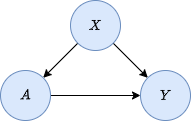

In [1]:
# if `drug_efficacy_graph.png` does not exist, download it from https://nyu.box.com/shared/static/7oxpdy3dkqbzv3v3xw0zx22ooc2xyvzh.png.
import os
import requests

if not os.path.exists('drug_efficacy_graph.png'):
    url = 'https://nyu.box.com/shared/static/7oxpdy3dkqbzv3v3xw0zx22ooc2xyvzh.png'
    r = requests.get(url)
    with open('drug_efficacy_graph.png', 'wb') as f:
        f.write(r.content)

from IPython.display import Image
Image('drug_efficacy_graph.png')

Let's now define the functional assignments as
\begin{align*}
&X \leftarrow H(\epsilon_X)\\
&A \leftarrow H(X  + \epsilon_A)\\
&Y \leftarrow H(0.25 A - X + \epsilon_Y),
\end{align*}
where $H$ is the Heaviside step function and all $\epsilon$'s are standard normal. We now generate data according to this SCM.

In [2]:
import numpy as np
import pandas as pd

def to_binary(x):
    return (x > 0).astype(int)

rng = np.random.RandomState(0)
n_examples = 1000
epsilon_x = rng.randn(n_examples)
epsilon_a = rng.randn(n_examples)
epsilon_y = rng.randn(n_examples)

x_to_a = 1
a_to_y = 0.25
x_to_y = -1

x = to_binary(epsilon_x)
a = to_binary(x_to_a * x + epsilon_a)
y = to_binary(a_to_y * a + x_to_y * x + epsilon_y)
df = pd.DataFrame({
    'X': x,
    'A': a,
    'Y': y
})

The dataset has three columns representing $X, A$, and $Y$. We'll start by computing $P(Y = 1 \mid A = 0)$ and $P(Y = 1 \mid A = 1)$.

In [3]:
for a in range(2):
  print(f'P(Y = 1 | A = {a}) = {df.Y[df.A == a].mean():.3f}')

P(Y = 1 | A = 0) = 0.386
P(Y = 1 | A = 1) = 0.374


The conditional probability of recovery is lower for patients that took the drug, i.e
\begin{align*}
  P(Y = 1 | A = 1) < P(Y = 1 | A = 0).
\end{align*}
It seems like the drug is ineffective.

Next, let's compute the probability of recovery separately for each age group.

In [4]:
for x in range(2):
  for a in range(2):
    print(f'P(Y = 1 | X = {x}, A = {a}) = {df.Y[(df.X == x) & (df.A == a)].mean():.3f}')

P(Y = 1 | X = 0, A = 0) = 0.467
P(Y = 1 | X = 0, A = 1) = 0.628
P(Y = 1 | X = 1, A = 0) = 0.127
P(Y = 1 | X = 1, A = 1) = 0.202


When we separately examine each age group, the conditional probability of recovery is higher for patients that took the drug, i.e.
\begin{align*}
P(Y = 1 \mid X = 0, A = 1) > P(Y = 1 \mid X = 0, A = 0),\\
P(Y = 1 \mid X = 1, A = 1) > P(Y = 1 \mid X = 1, A = 0).
\end{align*}

It seems nonsensical that the drug is ineffective if we ignore age, but becomes effective once we take age into account. This is called *Simpson's paradox*.

Marginalization is the key to understanding this. We have
\begin{align*}
  P(Y = 1 \mid A = 0) &= \sum_x P(Y = 1, X = x \mid A = 0)\\
  &= \sum_x P(Y = 1 \mid X = x, A = 0) P(X = x \mid A = 0)\\
  &= P(Y = 1 \mid X = 0, A = 0) P(X = 0 \mid A = 0) + P(Y = 1 \mid X = 1, A = 0) P(X = 1 \mid A = 0),
\end{align*}
and
\begin{align*}
  P(Y = 1 \mid A = 1) &= \sum_x P(Y = 1, X = x \mid A = 1)\\
  &= \sum_x P(Y = 1 \mid X = x, A = 1) P(X = x \mid A = 1)\\
  &= P(Y = 1 \mid X = 0, A = 1) P(X = 0 \mid A = 1) + P(Y = 1 \mid X = 1, A = 1) P(X = 1 \mid A = 1).
\end{align*}

This shows that the conditional probability $P(Y \mid A)$ depends on $P(X \mid A)$. The latter represents the relationship between drug taking and age. Let's calculate it, since we haven't done so yet.

In [5]:
for a in range(2):
    print(f'P(X = 1 | A = {a}) = {df.X[df.A == a].mean():.3f}')

P(X = 1 | A = 0) = 0.237
P(X = 1 | A = 1) = 0.596


Thus, we have
\begin{align*}
P(Y = 1 \mid A = 0) &= \color{blue}{0.467} * 0.763 + \color{red}{0.127} * 0.237 = 0.386,\\
P(Y = 1 \mid A = 1) &= \color{blue}{0.628} * 0.404 + \color{red}{0.202} * 0.596 = 0.374.
\end{align*}

Now we can mechanically understand why Simpson's paradox arises.
* $P(Y \mid A)$ is a weighted average of the recovery rate for each age group.
* The elderly tend to be prescribed the drug more.
* The elderly also tend to recover less.
* Due to these two factors, the overall recovery rate was higher for the non-drug-taking group.



The paradox occurs because we are using statistical quantities (conditional probabilities) to answer a causal question - "does the drug improve recovery?"

So far, we've instead been asking the statistical question - "were those who were prescribed the drug more likely to recover?" Notice that the answer to this question is influenced by age, which acted as a confounder.

The main activity of causal inference is to adjust for biases such as confounding in order to answer causal questions. We'll see how to do this for the drug efficacy example in next week's lab.